for new executions

# Set Variables

In [ ]:
# -------- dataset
# software_name = "Camel"
# software_name = "CloudStack"
# software_name = "Geode"
# software_name = "Hbase"


# --------
my_keyword_Based = True
# my_keyword_Based = False


# -------- my_balance_train & file_subversion
# my_balance_train = True
my_balance_train = False
file_subversion = ".2-balanced" if my_balance_train else ".1-imbalance"


# -------- my_conv_kernel_output_channel & output_version
my_conv_kernel_output_channel = 64
# outp_version
# v2: 64 filter
# v3: 8  filter
output_version = 2 if my_conv_kernel_output_channel == 64 else 3

In [ ]:
dataset_file_names = {
    "Camel":      "Camel_DE - v.02",
    "CloudStack": "CloudStack_DE - v.01",
    "Geode":      "Geode_DE - v.01",
    "Hbase":      "Hbase_DE - v.01"
}

dataset_file_name = dataset_file_names[software_name]

# Google Colab

In [ ]:
# Libs
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# load data from google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
!ls "/content/gdrive/My Drive/"

Mounted at /content/gdrive
'Colab Notebooks'   SAVE


In [ ]:
# project folder path
project_folder = "gdrive/MyDrive/Colab Notebooks/paper/"

# data folder path
data_folder =    "00- My Data/one-phase method/"

# output folder path
output_folder =  "01- Jupyter Notebook/50- one-phase method _ CNN/00. Output/"

In [ ]:
# dataset folder path
dataset_folder = software_name + "/"

# output data-folder path
output_data_folder = project_folder + output_folder + dataset_folder + dataset_file_name + "/"

# Libs

In [ ]:
import json
import os.path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from operator import truediv

from matplotlib.ticker import MaxNLocator

# Config

In [ ]:
mypaths = {
    "data": {
        "dataset":           project_folder + data_folder + dataset_folder + dataset_file_name + ".csv",
        "w2v_word_vectors":  project_folder + data_folder + "w2vGoogle.bin"
    },
    "output": {
        "not_keyword_based": {
            "performance":         output_data_folder + "performances/N_KB-performance-v{}{}_weight.json",
            "model":               output_data_folder + "models/N_KB-model-v{}{}.pth"
        },
        "keyword_based": {
            "tfidf_word_weights":  output_data_folder + "tfidf-word-weights-v01.json",
            "performance":         output_data_folder + "performances/KB-performance-v{}{}_weight.json",
            "model":               output_data_folder + "models/KB-model-v{}{}.pth"
        }
    }
}

preprocessing_params = {
    "data":{
        "dataset": {
            "columns_name":   ["text", "bug_class_2"],
            "columns_dtype" : {0: "str", 1: "int64"},
            "bug_classes": [0, 1],
            "num_bug_classes": 2
        }
    },
    "keyword_Based": my_keyword_Based,
}

In [ ]:
for k1, v1 in mypaths["output"].items():
    for k2, v2 in mypaths["output"][k1].items():
        mypaths["output"][k1][k2] = mypaths["output"][k1][k2].format(output_version, "{}")
        print(k1, k2)
        print(mypaths["output"][k1][k2])
        print("-" * 10)

not_keyword_based performance
gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/03- one-phased method _ CNN/00. Output/Hbase/Hbase_DE - v.01/performances/N_KB-performance-v2{}.json
----------
not_keyword_based model
gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/03- one-phased method _ CNN/00. Output/Hbase/Hbase_DE - v.01/models/N_KB-model-v2{}.pth
----------
keyword_based tfidf_word_weights
gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/03- one-phased method _ CNN/00. Output/Hbase/Hbase_DE - v.01/tfidf-word-weights-v01.json
----------
keyword_based performance
gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/03- one-phased method _ CNN/00. Output/Hbase/Hbase_DE - v.01/performances/KB-performance-v2{}.json
----------
keyword_based model
gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/03- one-phased method _ CNN/00. Output/Hbase/Hbase_DE - v.01/models/KB-model-v2{}.pth
----------


In [ ]:
mypaths

{'data': {'dataset': 'gdrive/MyDrive/Colab Notebooks/paper/00- My Data/one-phased method/Hbase/Hbase_DE - v.01.csv',
  'w2v_word_vectors': 'gdrive/MyDrive/Colab Notebooks/paper/00- My Data/one-phased method/w2vGoogle.bin'},
 'output': {'keyword_based': {'model': 'gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/03- one-phased method _ CNN/00. Output/Hbase/Hbase_DE - v.01/models/KB-model-v2{}.pth',
   'performance': 'gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/03- one-phased method _ CNN/00. Output/Hbase/Hbase_DE - v.01/performances/KB-performance-v2{}.json',
   'tfidf_word_weights': 'gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/03- one-phased method _ CNN/00. Output/Hbase/Hbase_DE - v.01/tfidf-word-weights-v01.json'},
  'not_keyword_based': {'model': 'gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/03- one-phased method _ CNN/00. Output/Hbase/Hbase_DE - v.01/models/N_KB-model-v2{}.pth',
   'performance': 'gdrive/MyDrive/Colab Notebooks/pape

In [ ]:
bcd_colours = ["blue", "green", "red"]

# ClassDistribution
In order to see whether dataset is `imbalance` or not.

In [ ]:
class ClassDistribution():
    def __init__(self, class_distributions):
        self.num_samples = sum(class_distributions.values())
        self.class_distributions = class_distributions # {"class0": num0, "class1": num1, ...}
        self.ratios = {} # {"1/0": ratio1, "1/2": ratio2, ...}
        self.percentage = {} # {"class0": perc0, "class1": perc1, ...}
    
    
    def calc_ratios(self):
        mydata_sorted = [(key, value) for key, value in sorted(self.class_distributions.items(), 
                                                               key=lambda item: item[1], reverse=True)]
        num_classes = len(self.class_distributions)
        for i in range(num_classes - 1):
            for j in range(i + 1, num_classes):
                tempKey1 = mydata_sorted[i][0]
                tempKey2 = mydata_sorted[j][0]
                mykey = tempKey1 + "/" + tempKey2
                
                tempValue1 = mydata_sorted[i][1]
                tempValue2 = mydata_sorted[j][1]
                self.ratios[mykey] = tempValue1 / tempValue2
    
    def calc_percentage(self):
        for key, value in self.class_distributions.items():
            tempPerc = (value * 100) / self.num_samples
            tempPerc = round(tempPerc)
            tempPerc = str(tempPerc) + "%"
            self.percentage[key] = tempPerc
    
    
    def plot_data(self, dataName):
        myclasses = list(self.class_distributions.keys())
        num_bugreports_perclass = list(self.class_distributions.values())

        fig, ax = plt.subplots(1, figsize=(5, 3))
        
        ax.bar(myclasses, num_bugreports_perclass, color ="maroon", label="Bug Reports", width=0.4)
        ax.set_xlabel("classes")
        ax.set_ylabel("Number of bug reports")
        ax.legend()
        ax.set_title("Number of bug reports PER classes [{}]".format(dataName))

        fig.tight_layout()

# CalculateMetrics

In [ ]:
class CalculateMetrics():
    def __init__(self, cm):
        self.cm = cm # it is a numpy object
        self.true_positives = np.diag(cm)
    
    
    # calculate precision for each class
    def calc_precision(self):
        columns_sum = np.sum(self.cm, axis=0)
        prec = list(map(truediv, self.true_positives, columns_sum))
        self.precision = prec
        return prec
    
    
    # calculate recall for each class
    # recall = accuracy per class
    # how accuratly each class is predicted
    def calc_recall(self):
        rows_sum = np.sum(self.cm, axis=1)
        rec = list(map(truediv, self.true_positives, rows_sum))
        self.recall = rec
        return rec
    
    
    # calculate f1_score for each class
    def calc_f1_score(self):
        tempPrec = np.array(self.precision)
        tempRec = np.array(self.recall)
        numerator = tempPrec * tempRec
        Denominator = tempPrec + tempRec
        f1s = 2 * (numerator / Denominator)
        self.f1_score = f1s
        return f1s
    
    def calc_accuracy(self):
        total_samples = np.sum(self.cm)
        sum_true_positives = sum(self.true_positives)
        acc = (sum_true_positives / total_samples)
        return acc

# Plot results

In [ ]:
class PlotResults():
    def __init__(self, train_data_status):
        self.ls = "solid"
        self.lw = 1
        self.lw_test = 5
        self.marker = "."
        self.marker_test = "o"
        self.class_labels = None
        self.data = None
        self.epochs = None
        self.train_data_status = train_data_status
    
    
    def load_results(self, result_path):
        with open(result_path) as filehandle:
            whole_data = json.load(filehandle)
        self.class_labels = whole_data["preprocessing_params"]["data"]["dataset"]["bug_classes"]
        self.epochs = whole_data["train_params"]["epochs"]
        self.best_step_index = whole_data["model_results"]["validation"]["best_at_step"] - 1
        self.best_step_label = whole_data["model_results"]["validation"]["best_at_step"]
        
        self.class_distributions = whole_data["class_distributions"]
        self.data = whole_data["model_results"]
    
    
    # ******************************* acc, cost *******************************
    
    def plot_acc_cost_(self):
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
        
        mymetrics = ["accuracy", "cost"]
        my_x = range(1, self.epochs + 1, 1)
        
        for ax, metric in zip(axes, mymetrics):
            ax.get_xaxis().set_major_locator(MaxNLocator(integer=True))
            
            if metric == "accuracy":
                ax.set_ylim([0, 100])
                ax.scatter(self.best_step_label, self.data["validation"]["best_acc"], 
                           label="best on Validation Dataset", color="cyan", lw=self.lw_test, marker=self.marker_test)
            else:
                ax.set_ylim([0, 300])
                ax.scatter(self.best_step_label, self.data["validation"]["cost"][self.best_step_index], 
                           label="best on Validation Dataset", color="cyan", lw=self.lw_test, marker=self.marker_test)
            
            ax.plot(my_x, metric, data=self.data["train"], label="Train-{} Dataset".format(self.train_data_status), 
                    color="red", linestyle=self.ls, lw=self.lw, marker=self.marker)
            
            ax.plot(my_x, metric, data=self.data["validation"], label="Validation Dataset", 
                    color="blue", linestyle=self.ls, lw=self.lw, marker=self.marker)
            
            ax.set_xlabel("epoch")
            ax.set_ylabel(metric)
            ax.legend()
            ax.grid(True)
            
            ax.get_xaxis().set_ticks( list(range(1, self.epochs + 1)) )
        # --- end for
        
        fig.tight_layout(pad=3.0)
        self.other_results()
    
    
    def other_results(self):
        print("** {} **".format(self.train_data_status))
        titles = ["validation_best_acc", "validation_best_acc_at_step", "epochs", "train accuracy", "cost"]
        titles = self.set_strings_to_equal_len_(titles)
        
        # accuracy
        tempTrAcc = round(self.data["train"]["accuracy"][self.best_step_index], 1)
        print("{}: {:2.1f}".format(titles[3], tempTrAcc) )
        
        tempValAcc = round(self.data["validation"]["best_acc"], 1)
        print("{}: {:2.1f}".format(titles[0], tempValAcc) )
        print("{}: {}".format(titles[1], self.data["validation"]["best_at_step"]))
        print("{}: {}".format(titles[2], self.epochs))
        
        # cost
        print()
        print("** {} **".format(self.train_data_status))
        print("{}: {:2.4f}".format(titles[4], self.data["validation"]["cost"][self.best_step_index]))
    
    
    def set_strings_to_equal_len_(self, words):
        max_len = 0
        longest_string_length = len(max(words, key=len))
        
        w = []
        for i, word in enumerate(words):
            temp = longest_string_length - len(word)
            w.append(word + " " * temp)
        return w
    
    
    # ******************************* confustion matrix *******************************
    
    def plot_confusion_matrices(self):
        
        fig_cf, axes_cd = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
        fig_cf.suptitle("Seaborn Confusion Matrix with labels")
        fig_cf.supxlabel("--Predicted-- Bug Report Category")
        fig_cf.supylabel("--Actual-- Bug Report Category")
        
        datasetNames = ["validation", "train"]
        i = 0
        
        for cfax, datasetName in zip(axes_cd, datasetNames):
            if datasetName == "train":
                mycbar = True
            else:
                mycbar = False
                
            tempCF = self.data[datasetName]["confusion_matrix"]
            cf_matrix = tempCF[self.best_step_index]
            cf_matrix = np.array(cf_matrix)
            
            calcmet = CalculateMetrics(cf_matrix)
            precision = calcmet.calc_precision()
            precision = [round(elem * 100) for elem in precision]
            
            recall = calcmet.calc_recall()
            recall = [round(elem * 100) for elem in recall]
            
            f1_score = calcmet.calc_f1_score()
            f1_score = [round(elem * 100) for elem in f1_score]
            
            acc = calcmet.calc_accuracy()
            acc = round(acc * 100)

            print("-" * 15, datasetName)
            print("precision          :", precision)
            print("recall             :", recall)
            print("f1_score           :", f1_score)
            print("accuracy           :", acc)
            
            snax = sns.heatmap(cf_matrix / np.sum(cf_matrix), 
                               annot=True, fmt=".2%", cmap="Blues", ax=cfax, vmin=0, vmax=1, 
                               cbar=mycbar, annot_kws={"size": 12})
            
            if datasetName == "train":
                snax.set_title("[{}-{}]\n".format(datasetName, self.train_data_status))
            else:
                snax.set_title("[{}]\n".format(datasetName))
            
            labels = list(map(str, self.class_labels))
            
            snax.xaxis.set_ticklabels(labels)
            snax.yaxis.set_ticklabels(labels)
            i += 1
        
        fig_cf.tight_layout(w_pad=6.0)
    
    
    # ******************************* class distribution *******************************
    
    def plot_class_distribution(self):
        # plot totlal class distribution for splited and whole dataset
        for dataName, v in self.class_distributions.items():
            print("-" * 15, dataName)
            tempCDist = ClassDistribution(v)
            tempCDist.calc_ratios()
            print("ratios     : ", tempCDist.ratios)
            tempCDist.calc_percentage()
            print("percentages: ", tempCDist.percentage)
            tempCDist.plot_data(dataName)
            print("\n")

## flow_plot_on_data

In [ ]:
def flow_plot_on_data(file_subversion, train_data_status, mypath):
    result_path = mypath.format(file_subversion)
    print(result_path)
    if os.path.isfile(result_path):
        plr = PlotResults(train_data_status)
        plr.load_results(result_path)

        plr.plot_acc_cost_()
        plr.plot_confusion_matrices()
        return plr
    else:
        print("There is no such file.")

In [ ]:
temp = "keyword_based" if my_keyword_Based else "not_keyword_based"
myp = mypaths["output"][temp]["performance"]
myp

'gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/03- one-phased method _ CNN/00. Output/Hbase/Hbase_DE - v.01/performances/KB-performance-v2{}.json'

## on imbalance data

gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/03- one-phased method _ CNN/00. Output/Hbase/Hbase_DE - v.01/performances/KB-performance-v2.1-imbalance.json
** imbalance **
train accuracy             : 93.1
validation_best_acc        : 64.0
validation_best_acc_at_step: 19
epochs                     : 20

** imbalance **
cost                       : 43.3443
--------------- validation
precision          : [75, 39]
recall             : [74, 40]
f1_score           : [74, 39]
accuracy           : 64
--------------- train
precision          : [97, 87]
recall             : [93, 94]
f1_score           : [95, 90]
accuracy           : 93


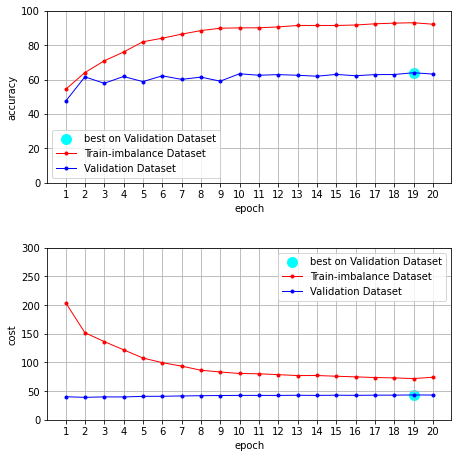

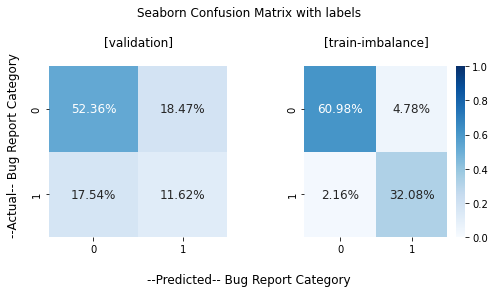

In [ ]:
plr1 = flow_plot_on_data(".1-imbalance", "imbalance", myp)

### class_distribution

--------------- whole
ratios     :  {'0/1': 2.0098135426889105}
percentages:  {'0': '67%', '1': '33%'}


--------------- train
ratios     :  {'0/1': 1.9206349206349207}
percentages:  {'0': '66%', '1': '34%'}


--------------- validation
ratios     :  {'0/1': 2.4283054003724396}
percentages:  {'0': '71%', '1': '29%'}




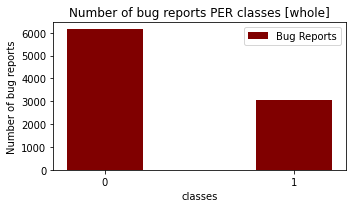

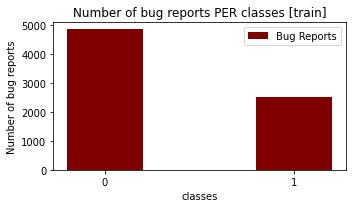

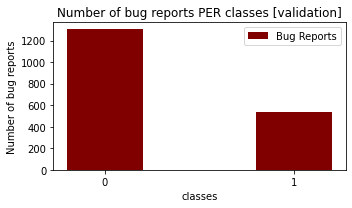

In [ ]:
plr1.plot_class_distribution()

## on balanced data

gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/03- one-phased method _ CNN/00. Output/Hbase/Hbase_DE - v.01/performances/KB-performance-v2.2-balanced.json
** balanced **
train accuracy             : 59.4
validation_best_acc        : 65.0
validation_best_acc_at_step: 1
epochs                     : 20

** balanced **
cost                       : 36.6967
--------------- validation
precision          : [65, 55]
recall             : [98, 5]
f1_score           : [78, 10]
accuracy           : 65
--------------- train
precision          : [65, 36]
recall             : [80, 22]
f1_score           : [72, 27]
accuracy           : 59


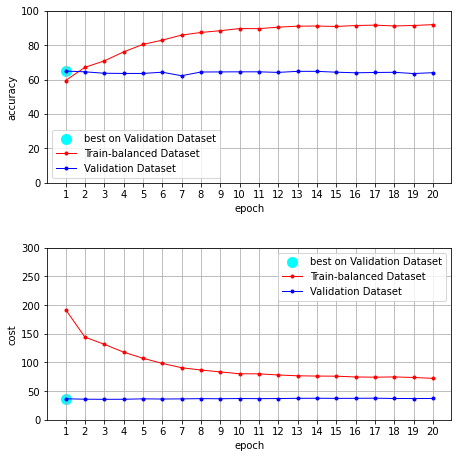

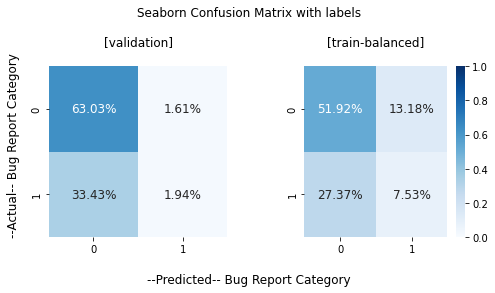

In [ ]:
plr2 = flow_plot_on_data(".2-balanced", "balanced", myp)

### class_distribution

--------------- whole
ratios     :  {'0/1': 2.0098135426889105}
percentages:  {'0': '67%', '1': '33%'}


--------------- train_balanced
ratios     :  {'0/1': 1.0610473256790816}
percentages:  {'0': '51%', '1': '49%'}


--------------- train
ratios     :  {'0/1': 2.0325504738360114}
percentages:  {'0': '67%', '1': '33%'}


--------------- validation
ratios     :  {'0/1': 1.9222222222222223}
percentages:  {'0': '66%', '1': '34%'}




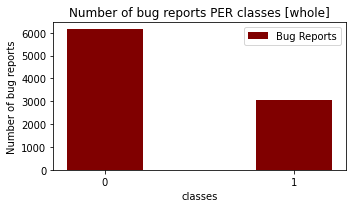

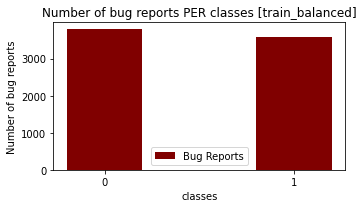

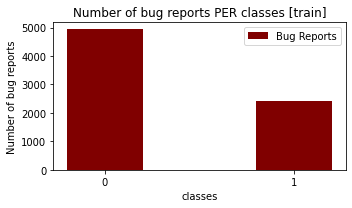

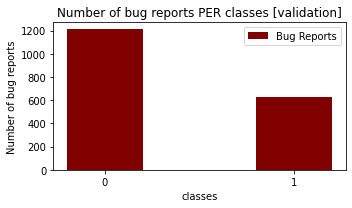

In [ ]:
if plr2:
    plr2.plot_class_distribution()
else:
    print("There is no such file.")